In [112]:
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

# Get the dataset

In [4]:
train_input, train_target, test_input, test_target  = prologue.load_data(cifar=False, one_hot_labels=True,
                                                                         normalize=False, flatten=False)
print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
train_input torch.Size([1000, 1, 28, 28]) train_target torch.Size([1000, 10])
test_input torch.Size([1000, 1, 28, 28]) test_target torch.Size([1000, 10])


# Model

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.MaxPool2d = nn.MaxPool2d(2, stride=2)
        
        
    def forward(self, x):
        x = self.MaxPool2d(F.relu(self.conv1(x)))
        x = self.MaxPool2d(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Training

In [65]:
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0
    
    for b in range(0, data_input.size(0), batch_size):
        output = model(data_input.narrow(0, b, batch_size))
        _, predicted_label = torch.max(output, 1)
        for k in range(batch_size):
            true_label = torch.argmax(data_target[b+k])
            if predicted_label[k] != true_label:
                nb_data_errors = nb_data_errors + 1
    
    return nb_data_errors

In [121]:
batch_size = 100
eta = 0.01
epochs = 250
def train_model(model, train_input, train_target, test_input, test_target):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)
    
    for i in range(epochs):
        
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            loss = criterion(output, train_target.narrow(0, b, batch_size).argmax(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if i%20 == 0:
            test_accuracy = compute_nb_errors(model, test_input, test_target)
            print("Epoch #", i, " test accuracy: ", test_accuracy/test_input.size(0))

In [122]:
net = Net()
train_model(net, train_input, train_target, test_input, test_target)

Epoch # 0  test accuracy:  0.809


KeyboardInterrupt: 

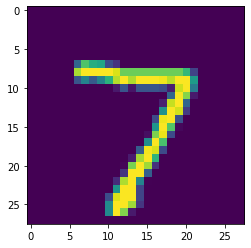

tensor(7)


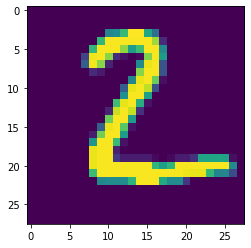

tensor(1)


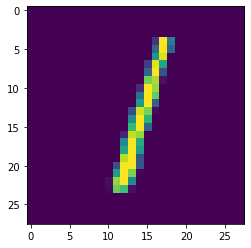

tensor(1)


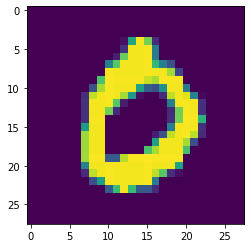

tensor(0)


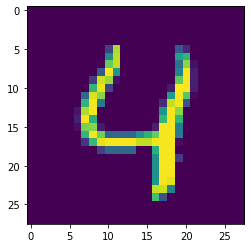

tensor(4)


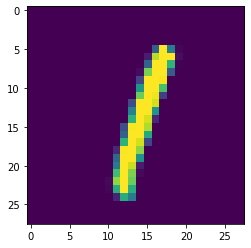

tensor(1)


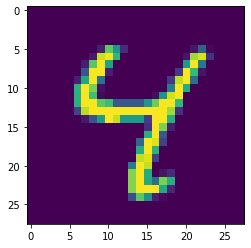

tensor(4)


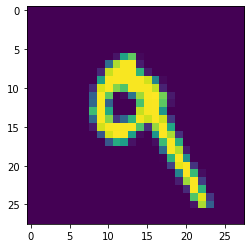

tensor(4)


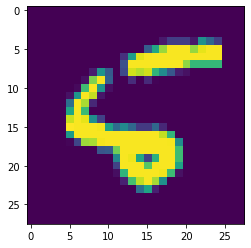

tensor(4)


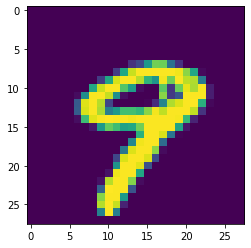

tensor(9)


In [119]:
res = net(test_input[0:10]).argmax(1)
for i in range(10):
    plt.imshow(test_input[i].view(28,28))
    plt.show()
    print(res[i])